In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import mnist
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd
import torch.nn.utils.prune as prune
from torchinfo import summary
from torch.nn.parameter import Parameter
import random
import pandas as pd
import math

In [2]:
#定义网络结构
class Net(nn.Module):
    def __init__(self, input, fc1, fc2, fc3, y, out):
        super(Net, self).__init__()
        
        # 定义全连接层
        self.fc1 = nn.Linear(input, fc1)
        self.act1 = nn.ReLU(inplace=True)
        
        """创建mask枝剪
        #custom_mask = torch.randint(0, 2, size=self.fc1.weight.shape)
        
        custom_mask = torch.tensor([[1, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 1],
        [1, 0, 1, 0],
        [1, 1, 1, 1],
        [0, 1, 1, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 0]])
        print (custom_mask)
        
        prune.custom_from_mask(self.fc1, 'weight', mask=custom_mask)
        """

        self.fc2 = nn.Linear(fc1, fc2)
        self.act2 = nn.ReLU(inplace=True)

        self.fc3 = nn.Linear(fc2, fc3)
        self.act3 = nn.ReLU(inplace=True)

        self.y = nn.Linear(fc3, y)
        
        self.out = nn.Linear(y, out, bias = False)
        
        
        """赋权重
        w_init = torch.ones(self.fc4.weight.shape)
        for i in range(len(w_init)):
            for j in range(len(w_init[i])):
                w_init[i][j] = float(random.randint(0, 1))
        #w_init = torch.rand(self.fc4.weight.shape)
        self.fc4.weight = Parameter(w_init)
        """
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.y(x)
        x = self.out(x)
        x = x.squeeze(-1)
        return x 

# 构建网络
net = Net(4, 512, 256, 128, 2, 1)

"""
#冻结层
for name, param in net.named_parameters():
    if "y" in name:
        param.requires_grad = False
"""        
summary(net)
#print (net.y.weight)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Linear: 1-1                            2,560
├─ReLU: 1-2                              --
├─Linear: 1-3                            131,328
├─ReLU: 1-4                              --
├─Linear: 1-5                            32,896
├─ReLU: 1-6                              --
├─Linear: 1-7                            258
├─Linear: 1-8                            2
Total params: 167,044
Trainable params: 167,044
Non-trainable params: 0

In [3]:
d = pd.read_csv('./data/ship_fuel_consumption_NN_1.csv')
d = d.dropna(axis=0,how='any')
d.to_csv('./data/ship_fuel_consumption_NN_2.csv', index = False)

In [4]:
class ShipDataset(Dataset):
    """ 数据集演示 """
    def __init__(self, csv_file, x1, x2):
        """实现初始化方法，在初始化的时候将数据读载入"""
        self.df = pd.read_csv(csv_file).iloc[x1:x2]
        
    def __len__(self):
        '''
        返回df的长度
        '''
        return len(self.df)
    def __getitem__(self, idx):
        #data = ((self.df.iloc[idx].STW, self.df.iloc[idx].avgLEVEL, self.df.iloc[idx].headwind, self.df.iloc[idx].crosswind), self.df.iloc[idx].fuelConsumption)
        input0 = torch.tensor(np.expand_dims(self.df.iloc[idx].STW, 0))
        input1 = torch.tensor(np.expand_dims(self.df.iloc[idx].avgLEVEL, 0))
        input2 = torch.tensor(np.expand_dims(self.df.iloc[idx].headwind, 0))
        input3 = torch.tensor(np.expand_dims(self.df.iloc[idx].crosswind, 0))
        data0 = torch.cat((input0, input1, input2, input3))
        data1 = self.df.iloc[idx].fuelConsumption
        tup = (data0, data1)
        return tup

In [5]:
train = ShipDataset('./data/ship_fuel_consumption_NN_2.csv', 0, 160000)
test = ShipDataset('./data/ship_fuel_consumption_NN_2.csv', 160001, 166587)

In [6]:
train_data = DataLoader(train, batch_size=64, shuffle=False)
test_data = DataLoader(test, batch_size=128, shuffle=False)

In [7]:
# 定义损失函数--mse就是均方差
criterion = nn.MSELoss()
# 定义优化器---随机梯度下降
optimizer = optim.SGD(net.parameters(), lr=1e-2)

In [8]:
# 开始训练
# 记录训练损失
losses = []
# 记录训练精度
acces = []
# 记录测试损失
eval_losses = []
# 记录测试精度
eval_acces = []
# 设置迭代次数
nums_epoch = 1
# 设置准确度小数点
dot = 100

for epoch in range(nums_epoch):
    train_loss = 0
    train_acc = 0
    net = net.train()
    for batch, (input, fuel) in enumerate(train_data):    
        input = input.to(torch.float32)
        fuel = fuel.to(torch.float32)
        input = input.reshape(input.size(0), -1)    #标准化
        input = Variable(input)    #包装张量，方便反向传播
        fuel = Variable(fuel)

        # 前向传播
        out = net(input)
        loss = criterion(out, fuel)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        pred = out
        num_correct = 0
        for i in range(input.shape[0]):
            if (math.floor(pred[i].item()*dot)/dot) == (math.floor(fuel[i].item()*dot)/dot):
                num_correct += 1
        acc = num_correct / input.shape[0]

        if (batch + 1) % 200 == 0:
            print('[INFO] Epoch-{}-Batch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f}'.format(epoch + 1,
                                                                                 batch+1,
                                                                                 loss.item(),
                                                                                 acc))
            
        train_acc += acc

    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))

    eval_loss = 0
    eval_acc = 0
    
    
    # 测试集不训练
    for batch, (input, fuel) in enumerate(test_data):     
        input = input.to(torch.float32)
        fuel = fuel.to(torch.float32)
        input = input.reshape(input.size(0), -1)    
        input = Variable(input)   
        fuel = Variable(fuel)

        # 前向传播
        out = net(input)
        loss = criterion(out, fuel)
        # 记录误差
        eval_loss += loss.item()

        pred = out
        num_correct = 0
        for i in range(input.shape[0]):
            if (math.floor(pred[i].item()*dot)/dot) == (math.floor(fuel[i].item()*dot)/dot):
                num_correct += 1
        acc = num_correct / input.shape[0]
        
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))

    print('[INFO] Epoch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f} | Test: Loss-{:.4f}, Accuracy-{:.4f}'.format(
        epoch + 1, train_loss / len(train_data), train_acc / len(train_data), eval_loss / len(test_data),
        eval_acc / len(test_data)))
    

[INFO] Epoch-1-Batch-200: Train: Loss-0.0068, Accuracy-0.0000
[INFO] Epoch-1-Batch-400: Train: Loss-0.0060, Accuracy-0.0000
[INFO] Epoch-1-Batch-600: Train: Loss-0.0002, Accuracy-0.2969
[INFO] Epoch-1-Batch-800: Train: Loss-0.0000, Accuracy-0.5312
[INFO] Epoch-1-Batch-1000: Train: Loss-0.0001, Accuracy-0.4531
[INFO] Epoch-1-Batch-1200: Train: Loss-0.0060, Accuracy-0.1875
[INFO] Epoch-1-Batch-1400: Train: Loss-0.0011, Accuracy-0.0156
[INFO] Epoch-1-Batch-1600: Train: Loss-0.0001, Accuracy-0.3438
[INFO] Epoch-1-Batch-1800: Train: Loss-0.0007, Accuracy-0.0625
[INFO] Epoch-1-Batch-2000: Train: Loss-0.0006, Accuracy-0.0469
[INFO] Epoch-1-Batch-2200: Train: Loss-0.0013, Accuracy-0.1094
[INFO] Epoch-1-Batch-2400: Train: Loss-0.0001, Accuracy-0.4062
[INFO] Epoch-1: Train: Loss-0.0143, Accuracy-0.1763 | Test: Loss-0.0052, Accuracy-0.0433


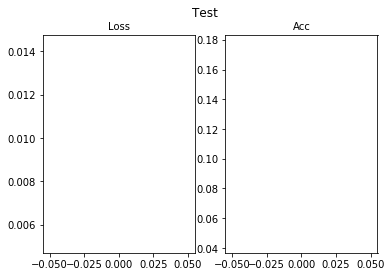

In [9]:
plt.figure()
plt.suptitle('Test', fontsize=12)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(eval_losses, color='r')
ax1.plot(losses, color='b')
ax1.set_title('Loss', fontsize=10, color='black')
ax2 = plt.subplot(1, 2, 2)
ax2.plot(eval_acces, color='r')
ax2.plot(acces, color='b')
ax2.set_title('Acc', fontsize=10, color='black')
plt.show()